<div align="right">
<a href="/python/sample-notebooks/#Download-and-run-the-sample-notebooks" class="btn">Download the samples</a> <a href="http://notebooks.esri.com/notebooks/samples/05_content_publishers/using_and_updating_GIS_content.ipynb" class="btn">Try it live</a>
</div>

# Using and updating GIS content

The GIS is a warehouse of geographic content and services. Arcgis includes several classes to make use of these content, publish new items and update the them when needed. This sample on updating the content of web maps and web scenes will demonstrate the following
 * **Replace web layers** of a web map. For instance, you can use this to update a web map when the services it points to were deleted. During the process, the sample shows how to read a web feature layer as a **FeatureService** object and inspect its properties.
 * **Drive the map widget by code**. In addition to displaying the interactive map widget, you can also set it to load at a particular extent. This is great for presentation purposes. During this process, the sample shows how to create and use a **MapView** object and a **Geocoder** object.
 * Make a **copy of a public web scene** item into your contents and then update it.
     * Edit the list of layers to remove unnecessary ones.
     * **Replace the basemap** of the web scene. In this step the sample shows how to search for **groups** and query the member items.
     * Change visibility of layers.

In [1]:
from arcgis.gis import GIS
from IPython.display import display

gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")

## Data preparation
To run through the sample, we require some published web layers, web maps and web scene items. This section contains cells that show how to publish them. If you would like to work with your own datasets or have these items already published, you can skip this section. To understand the publishing process in detail, check out other samples within this samples directory.

In [2]:
sd_file = "data/updating_gis_content/Ebola_Treatment_Units.sd"
# add the sd file as an item and publish it as a web layer
item = gis.content.add({},sd_file)
new_item = item.publish()

Now that the web layers are published, run through this section to publish a web map. To understand how this part of the sample works, refer to the sample titled **Publishing web maps and web scenes**

In [3]:
import json
web_map_json = str()

# read web map json from text file
with open("data/updating_gis_content/web_map_Ebola.json","r") as file_handle:
    web_map_json = json.load(file_handle)

# publish a web map
web_map_item_properties = {'title':'Ebola treatment locations',
                          'type':'Web Map',
                          'snippet':'This map shows locations of Ebola treatment centers in Africa',
                          'tags':'ArcGIS Python API',
                          'text':json.dumps(web_map_json)}

web_map_item = gis.content.add(web_map_item_properties)

# Using and updating a web map
In the data preparation section above, we published a web map to play with. We will search for that web map, draw it and update it if necessary.

In [4]:
search_result = gis.content.search("title:Ebola treatment locations", item_type = "Web Map")
display(search_result)

[<Item title:"Ebola treatment locations" type:Web Map owner:demo_deldev>]

In [5]:
# display the first search result to confirm the item
web_map_item = search_result[0]
display(web_map_item)

<Item title:"Ebola treatment locations" type:Web Map owner:demo_deldev>

In [6]:
import arcgis

# create a web map object out of the item
web_map_obj = arcgis.mapping.WebMap(web_map_item)

# display the web map obj in an interactive widget
web_map_obj

## Fix errors in web map
The widget loads an empty web map with just a basemap. Let us investigate the contents of the web map to determine the issue. Let us start with `operationalLayers` dictionary which contains the list of layers and inspect each layer.

In [7]:
layer_list = web_map_obj['operationalLayers']
display(layer_list)

[{'id': 'layer1',
  'itemId': 'f53d5907296e43e28e8570a24b1d1d26',
  'layerType': 'ArcGISFeatureLayer',
  'opacity': 1,
  'title': 'Ebola_Treatment_Units - Ebola_Treatment_Units_Classed',
  'url': 'https://services.arcgis.com/ORGID/arcgis/rest/services/Ebola_Facilities/FeatureServer/1',
  'visibility': True}]

The web map has only 1 layer and that points to a feature service title **Ebola_Facilities**. Let us verify if a feature service of that name exists on the server. If not, let us try to find the closest match.

In [8]:
search_result = gis.content.search('title:Ebola_Facilities', item_type = 'Feature Service')
display(search_result)

[]

Let us change the search query leaving just the word `Ebola` in the title.

<Item title:"Ebola_Treatment_Units" type:Feature Service owner:demo_deldev>
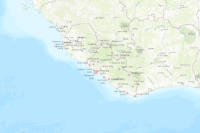

In [9]:
search_result = gis.content.search('title:Ebola', item_type='Feature Layer')
search_result[0]

It is likely the old service was deleted and a new one was with a different name was published. Let us update the web map dictionary with the correct url. But before that, we need to investigate if the new service also has layer with id `1` like the previous service.

In [10]:
ebola = search_result[0]
ebola.layers

[<FeatureLayer url:"http://services6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/Ebola_Treatment_Units/FeatureServer/0">,
 <FeatureLayer url:"http://services6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/Ebola_Treatment_Units/FeatureServer/1">]

The new feature service does have a layer with id `1`. Hence we can use the same layer id while switching the url. While updating the web map, it is important to not only update the **url** but also the **itemId** of the feature service item.

In [11]:
# set the url to feature service item's url
layer_list[0]['url'] = ebola.layers[1].url
layer_list[0]['itemId'] = search_result[0].id

# update the web map object's operationalLayers dictionary
web_map_obj['operationalLayers'] = layer_list

## Update the web map
Now the web map should be fixed as it points to a live service. To update the web map, we call the `update()` method.

In [12]:
# Let us print the opertationalLayers dictionary before calling the update()
web_map_obj['operationalLayers']

[{'id': 'layer1',
  'itemId': 'a24ae8550ea34a449699479b7e35217d',
  'layerType': 'ArcGISFeatureLayer',
  'opacity': 1,
  'title': 'Ebola_Treatment_Units - Ebola_Treatment_Units_Classed',
  'url': 'http://services6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/Ebola_Treatment_Units/FeatureServer/1',
  'visibility': True}]

In [13]:
web_map_obj.update()

Let us create a new web map object and try to draw it.

In [14]:
search_result = gis.content.search('title: Ebola_treatment_locations', item_type = "Web Map")
display(search_result)

[<Item title:"Ebola treatment locations" type:Web Map owner:demo_deldev>]

In [15]:
web_map_item = search_result[0]
web_map_obj = arcgis.mapping.WebMap(web_map_item)
web_map_obj

The web map was sucessfully overwritten with correct operational layers. You can interact with the widget and zoom into the African coast to observe the locations of Ebola treatment centers.

# Using and updating a web scene
In the sample above we observed how to update a web map. Updating the web scene is similar, we use the `update()` method. Let us look at the example of a web scene that displays tropical cyclones over the Pacific ocean.

<Item title:"Western Pacific Typhoons (2005)" type:Web Scene owner:esri_3d>
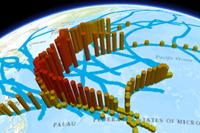

In [16]:
search_result = gis.content.search('title:Western Pacific Typhoons (2005) AND owner:esri_3d', 
                                   item_type = 'Web Scene', outside_org = True)
search_result[0]

Lets display the web scene in the notebook.

In [17]:
web_scene_item = search_result[0]
web_scene_obj = arcgis.mapping.WebScene(web_scene_item)

# display web scene in the notebook
web_scene_obj

This is a great web scene and it displays a lot of hurricane tracks. However, we want to create a new one with only a particular subset of data and customize the basemaps. To modify this web scene, let us first make a copy of it and publish it into your portal.

## Make a copy of the public web scene item
To make a copy, we essentially download the content of the web scene JSON, remove the parts we don't want, add the layers that we want and publish a new item using that information. The publishing steps is similar to what is described earlier in the **data preparation** section and in detail in the sample titled **Publishing web maps and web scenes**.

Let's say, we are only interested in the storms that occur in summer. Summer in tropical Asia is around April-June and that matches with a layer in the existing web scene. Let us query the `operationalLayers` section of the web scene to understand how the layers look like.

### Update operational layers of new web scene

In [18]:
display(web_scene_obj['operationalLayers'])

[{'id': '882ce65eceda4e2ba2ad65f9e2c0632f',
  'layerDefinition': {'drawingInfo': {'renderer': {'description': '',
     'label': '',
     'symbol': {'symbolLayers': [{'material': {'color': [0, 169, 230],
         'transparency': 0},
        'size': 5,
        'type': 'Line'}],
      'type': 'LineSymbol3D'},
     'type': 'simple'}},
   'elevationInfo': {'mode': 'onTheGround'},
   'minScale': 120000000},
  'layerType': 'ArcGISFeatureLayer',
  'opacity': 1,
  'popupInfo': {'description': '<div><p><span style="font-weight:bold;">Typhoon {name}</span></p><p><span style="font-weight:bold;">Started: </span><span>{datedescription}</span></p></div>',
   'mediaInfos': [],
   'title': '{name}'},
  'title': 'Typhoon Paths',
  'url': 'http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/18',
  'visibility': True},
 {'id': '14a37c86f84-layer21',
  'layerType': 'GroupLayer',
  'layers': [{'id': '7a24e304d2474d7eb29a712c95202140',
    'layerDefinition':

There is a lot of information displayed above. Let us drill into this and display only layer names and their urls. If you notice, some of the layers above are group layers, meaning, they contain sub layers. So let us write a loop like below and print some details.

In [19]:
for layer in web_scene_obj['operationalLayers']:
    print(layer['title'] + " :: " + layer['layerType'])
    if layer['layerType'] == 'GroupLayer':
        for sub_layer in layer['layers']:
            print("\t" + sub_layer['title'] + " :: "+ sub_layer['url'])

Typhoon Paths :: ArcGISFeatureLayer
October - December :: GroupLayer
	Labels Q4 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/17
	Typhoons Q4 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/16
September :: GroupLayer
	Labels Q3_3 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/14
	Typhoons Q3_3 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/13
August :: GroupLayer
	Labels Q3_2 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/11
	Typhoons Q3_2 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/10
July :: GroupLayer
	Labels Q3_1 :: http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/8
	Typhoons Q3

We are only interested in the layers that correspond to cyclones in summer. From the above report, we understand that information is in a group layer with two sub layers. Let us extract just that dictionary and compose a new web scene data.

In [20]:
# Let us construct a list comprehension and mine out that group layer.
subset_op_layers = [subset for subset in web_scene_obj['operationalLayers'] if subset['title'] == 'April - June']
display(subset_op_layers)

[{'id': '14a37c397dc-layer17',
  'layerType': 'GroupLayer',
  'layers': [{'id': '56803f3d64184140950f0ef1256a0603',
    'layerDefinition': {'drawingInfo': {'renderer': {'description': '',
       'label': '',
       'symbol': {'name': 'Pushpin 1',
        'styleName': 'EsriIconsStyle',
        'type': 'styleSymbolReference'},
       'type': 'simple',
       'visualVariables': [{'axis': 'all',
         'minSize': 25,
         'type': 'sizeInfo',
         'valueUnit': 'unknown'}]}},
     'elevationInfo': {'mode': 'absoluteHeight'}},
    'layerType': 'ArcGISFeatureLayer',
    'opacity': 1,
    'showLabels': True,
    'title': 'Labels Q2',
    'url': 'http://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/PacificTyphoons2005_WFL/FeatureServer/5',
    'visibility': False},
   {'id': '72668fcc8a904bd6a1444bef2e72f420',
    'layerDefinition': {'drawingInfo': {'renderer': {'description': '',
       'label': '',
       'symbol': {'name': 'Standing Cylinder',
        'styleName': 'EsriT

In [21]:
# Let us apply the changes to a new web scene object.
new_web_scene_obj = web_scene_obj
new_web_scene_obj['operationalLayers'] = subset_op_layers

### Update basemap of new web scene
We now have the necessary `operationalLayers` information. Let us also try to change the basemap to a darker shade. First let us search the basemaps available in the current portal. If no suitable one is found, we can widen the search outside the organization and use a basemap published by Esri.

**Basemaps** are web maps that are stored in a **group** usually called **Basemaps**. Thus to get the list of basemaps available on a portal, we can find the basemaps group and list all web maps that are a part of it.

To get the list of groups on the portal, we use `groups` property of the `GIS` class.

<Item title:"Dark Gray Canvas" type:Web Map owner:esri>
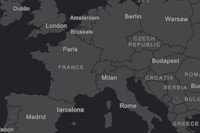

['basemap', 'esri_basemap', 'vector', 'canvas', 'dark', 'esri_vector']


<Item title:"Dark Gray Canvas" type:Web Map owner:esri>
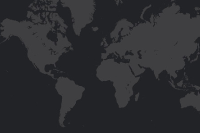

['neutral', 'subdued', 'canvas', 'shaded', 'world', 'Global', 'basemap', 'current', 'gray', 'grey', 'dark gray', 'dark grey', 'esri', 'esri_basemap']


In [22]:
basemap_search = gis.content.search('title:dark AND owner:esri', 
                                    outside_org=True, item_type='web map')
for item in basemap_search:
    display(item)
    print(item.tags)

We have found the basemap of our choice. Let us read it as a **`WebMap`** object and query the `baseMap` dictionary.

In [23]:
dark_basemap_item = basemap_search[1]
dark_basemap_obj = arcgis.mapping.WebMap(dark_basemap_item)
dark_basemap_obj['baseMap']

{'baseMapLayers': [{'id': 'layer0',
   'layerType': 'ArcGISTiledMapServiceLayer',
   'opacity': 1,
   'title': 'World_Dark_Gray_Base',
   'url': 'https://services.arcgisonline.com/arcgis/rest/services/Canvas/World_Dark_Gray_Base/MapServer',
   'visibility': True},
  {'id': 'World_Dark_Gray_Reference_8618',
   'isReference': True,
   'layerType': 'ArcGISTiledMapServiceLayer',
   'opacity': 1,
   'title': 'World_Dark_Gray_Reference',
   'url': 'https://services.arcgisonline.com/arcgis/rest/services/Canvas/World_Dark_Gray_Reference/MapServer',
   'visibility': True}],
 'title': 'Dark Gray Canvas'}

Now let us explore how the `baseMap` dictionary of the **web scene** looks like.

In [24]:
new_web_scene_obj['baseMap']

{'baseMapLayers': [{'id': '73e9780a7d6f413f8547abbd19ec786c',
   'layerType': 'ArcGISTiledMapServiceLayer',
   'url': 'http://services.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer'}],
 'elevationLayers': [{'id': 'globalElevation_0',
   'layerType': 'ArcGISTiledElevationServiceLayer',
   'url': 'http://elevation3d.arcgis.com/arcgis/rest/services/WorldElevation3D/Terrain3D/ImageServer'}],
 'id': 'basemap',
 'title': 'Topographic',
 'visibility': True}

To get the desired basemap, we need to update the only `url` key-value pair of the web scene's `baseMap` dictionary. Here we will only pick the first layer of the dark basemap web map.

In [25]:
new_web_scene_obj['baseMap']['baseMapLayers'][0]['url'] = \
dark_basemap_obj['baseMap']['baseMapLayers'][0]['url']

Now that we have performed the necessary updates, we can go ahead and publish this as a new web scene item on our portal.

In [26]:
new_web_scene_properties= {'title':'Toprical Cyclones - Summer',
                          'type' : 'Web Scene',
                          'tags' : 'ArcGIS Python API',
                          'snippet' : str.format('Subset of <a href={2}>{0}</a> published by {1}',
                                                 web_scene_item.title, web_scene_item.owner,
                                                "https://www.arcgis.com/home/item.html?id=" + web_scene_item.id),
                          'text' : json.dumps(new_web_scene_obj)}

new_item = gis.content.add(new_web_scene_properties)
new_item

<Item title:"Toprical Cyclones - Summer" type:Web Scene owner:demo_deldev>

We have successfully published the new web scene. Now let us display in an interactive widget and observe if it has the necessary updates.

In [27]:
new_item.share(True)
new_web_scene_obj = arcgis.mapping.WebScene(new_item)
new_web_scene_obj

Our required updates have been applied to the new web scene. However notice the **April - June** layer is **turned off** by default. Let us fix that and update the web scene.

Let us query the `operationalLayer` dictionary of the new web scene and look for a key called `visibility`.

In [28]:
for layer in new_web_scene_obj['operationalLayers']:
    print(layer['visibility'])

False


As we know, there is just 1 group layer and it is turned off. Let us change that and update the web scene.

In [29]:
for layer in new_web_scene_obj['operationalLayers']:
    layer['visibility'] = True

To update the web scene call the `update()` method on the web scene object.

In [30]:
new_web_scene_obj.update()
new_web_scene_obj

# Summary
In this sample, we observed how to consume web maps, web scenes and how to update them. During this process, the sample showed how to read a web feature layers, how to use geocoding to get co-ordinates of a point of interest, how to modify the map widget using code, how to make copy of an existing item into your account, how to look for basemaps and finally, how to update layer properties within a web scene.